# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [1]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import string
import random
import networkx as nx
import seaborn as sns

from model.training.rollout_data import PriorityReplayBuffer as Buffer
from task.gridworld import CnnWrapper, ThreadTheNeedleEnv, OpenEnv
from utils.config_utils import parse_task_config, parse_model_config, load_config
from utils.pytorch_utils import DEVICE
from model.agents.sb_discrete_ppo import DiscretePpo as AgentClass

from utils.pytorch_utils import (
    convert_float_to_8bit
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.2.1
device = mps


In [3]:
CONFIG_PATH = "configs"
TASK_CONFIG_FILE = "env_config.yml"
VAE_CONFIG_FILE = "vae_config.yml"
AGENT_CONFIG_FILE = "discrete_ppo_config.yml"

TASK_NAME = "thread_the_needle"
MODEL_NAME = "cnn_vae"

random_id = ''.join(random.choice(string.ascii_uppercase) for _ in range(6))
LOGGING_TAG = f'OpenEnv-ppoW1.0-detach{random_id}'


# Create log dir
LOG_DIR = "tmp/"
os.makedirs(LOG_DIR, exist_ok=True)

TASK_CLASS = ThreadTheNeedleEnv
# AgentClass = StableBaselinesPPO

## Load Configs
task_config_file = os.path.join(CONFIG_PATH, TASK_CONFIG_FILE)
vae_config_file = os.path.join(CONFIG_PATH, VAE_CONFIG_FILE)
agent_config_file = os.path.join(CONFIG_PATH, AGENT_CONFIG_FILE)

env_kwargs = parse_task_config(TASK_NAME, task_config_file)
vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)

# create the task and get the optimal policy
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))
pi, _ = task.get_optimal_policy()

SAVE_FILE_NAME = f"simulations/thread_the_needle_viagent_offline.csv"

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# create the task and get the optimal policy
task = TASK_CLASS.create_env(**env_kwargs)
task = CnnWrapper(task)

# create the monitor
task = Monitor(task, LOG_DIR)

pi, _ = task.get_optimal_policy()
# training_kwargs["optimal_policy"] = pi

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_optimal_policy to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_optimal_policy` for environment variables or `env.get_wrapper_attr('get_optimal_policy')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# dir(task.action_space)
task.action_space.n


4

In [6]:
import inspect

# Get the signature of the __init__ method of DiscretePPO
sig = inspect.signature(AgentClass.__init__)

# Iterate through the parameters to separate args and kwargs
args = []
kwargs = []
for param in sig.parameters.values():
    # Skip 'self' parameter for methods
    if param.name == 'self':
        continue
    if param.default == inspect.Parameter.empty:
        args.append(param.name)
    else:
        kwargs.append(param.name)

print("Args:", args)
print("Kwargs:", kwargs)

Args: ['args', 'kwargs']
Kwargs: ['vae_coef']


In [7]:
agent_config

{'vae_model_class': 'StateVae',
 'n_train_steps': 30000,
 'n_batches': 12,
 'value_iteration_kwargs': {'gamma': 0.9,
  'n_iter': 1000,
  'softmax_gain': 1.0,
  'epsilon': 0.05,
  'batch_length': 'None'},
 'state_inference_model': {'batch_size': 64,
  'n_epochs': 10,
  'grad_clip': 1.0,
  'n_steps': 2048,
  'persistant_optim': True}}

In [8]:
### Model + Training Parameters

vae_config = parse_model_config(MODEL_NAME, vae_config_file)
agent_config = load_config(agent_config_file)


def make_model():
    ppo = AgentClass(
        "CnnPolicy",
        task,
        verbose=1,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        vae_coef=1.0,
        # policy_kwargs=dict(features_extractor_kwargs=dict(tau=0.05, z_dim=8, z_layers=8)),
        policy_kwargs=dict(features_extractor_kwargs=dict(tau=0.01, tau_annealing_rate=0.85, z_dim=8, z_layers=8)),
        # policy_kwargs=dict(features_extractor_kwargs=dict(tau=10.0, tau_annealing_rate=0.5, z_dim=32, z_layers=16)),
    )
    # ppo = ppo.to(DEVICE)
    return ppo

agent = make_model()
# total_params = sum(p.numel() for p in agent.state_inference_model.parameters())
# print(f"Number of parameters: {total_params}")

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [9]:
agent

In [10]:
agent = make_model()

# agent.learn(total_timesteps=10000, progress_bar=True) # previous model
agent.learn(total_timesteps=2048*5, progress_bar=True)
# agent.learn(total_timesteps=1000, progress_bar=True, capacity=750)

Output()

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 170      |
|    ep_rew_mean     | -14.5    |
| time/              |          |
|    fps             | 916      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | -14.6       |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 2           |
|    time_elapsed         | 53          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015146683 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -0.0134     |
|    learning_rate        | 0.0003      |
|    loss                 | 36.1        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000996   |
|    vae_elbo             | 149         |
|    value_loss           | 1.37        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 177         |
|    ep_rew_mean          | -16.2       |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 3           |
|    time_elapsed         | 105         |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.027471729 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.318       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.2        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00339    |
|    vae_elbo             | 32.1        |
|    value_loss           | 1.18        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 134         |
|    ep_rew_mean          | -11.5       |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 4           |
|    time_elapsed         | 157         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012495549 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.2        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00747    |
|    vae_elbo             | 27.2        |
|    value_loss           | 0.984       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 96.2       |
|    ep_rew_mean          | -7.16      |
| time/                   |            |
|    fps                  | 48         |
|    iterations           | 5          |
|    time_elapsed         | 210        |
|    total_timesteps      | 10240      |
| train/                  |            |
|    approx_kl            | 0.01792695 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.331      |
|    learning_rate        | 0.0003     |
|    loss                 | 23.2       |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0134    |
|    vae_elbo             | 24         |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.7       |
|    ep_rew_mean          | -1.06      |
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 6          |
|    time_elapsed         | 263        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.02522014 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.29      |
|    explained_variance   | 0.649      |
|    learning_rate        | 0.0003     |
|    loss                 | 23.4       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0172    |
|    vae_elbo             | 20.8       |
|    value_loss           | 3.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.6        |
|    ep_rew_mean          | 0.88        |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 7           |
|    time_elapsed         | 328         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.021757869 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.5        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0166     |
|    vae_elbo             | 20.8        |
|    value_loss           | 2.32        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.6        |
|    ep_rew_mean          | 0.527       |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 8           |
|    time_elapsed         | 391         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.025349662 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.8        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0204     |
|    vae_elbo             | 20.1        |
|    value_loss           | 1.65        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.7        |
|    ep_rew_mean          | 0.302       |
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 9           |
|    time_elapsed         | 447         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.021584567 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.4        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00693    |
|    vae_elbo             | 19.3        |
|    value_loss           | 1.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.8        |
|    ep_rew_mean          | 1.7         |
| time/                   |             |
|    fps                  | 40          |
|    iterations           | 10          |
|    time_elapsed         | 506         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.018073473 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.9        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0128     |
|    vae_elbo             | 18          |
|    value_loss           | 1.26        |
-----------------------------------------


In [11]:
rollouts = Buffer()
# rollouts = agent.collect_buffer(task, rollouts, 10000, epsilon=0.01)
rollouts = agent.collect_buffer(task, rollouts, 10000, epsilon=0.05)
rollouts.transpose_obs([2, 0, 1])


Collection rollouts: 100%|██████████| 10000/10000 [00:13<00:00, 741.78it/s]


In [12]:
np.argwhere(rollouts.get_dataset()['rewards'] > 0.0)

array([[2061],
       [2182],
       [2274],
       [2307],
       [2540],
       [2564],
       [2609],
       [3171],
       [3219],
       [3783],
       [3890],
       [3991],
       [4276],
       [4351],
       [4370],
       [4500],
       [4516],
       [4522],
       [4529],
       [4543],
       [4654],
       [4701],
       [4778],
       [4785],
       [4801],
       [4848],
       [4854],
       [4934],
       [4997],
       [5085],
       [5120],
       [5187],
       [5214],
       [5230],
       [5266],
       [5308],
       [5312],
       [5314],
       [5317],
       [5322],
       [5326],
       [5352],
       [5378],
       [5402],
       [5436],
       [5444],
       [5555],
       [5558],
       [5567],
       [5573],
       [5603],
       [5611],
       [5668],
       [5677],
       [5691],
       [5746],
       [5809],
       [5824],
       [5852],
       [5859],
       [5871],
       [5937],
       [6041],
       [6059],
       [6091],
       [6176],
       [62

In [13]:
dataset = rollouts.get_dataset()
dataset['observations'].shape

(9991, 1, 64, 64)

In [15]:
Laplacian, state_key = agent.get_graph_laplacian(rollouts)

Found 537 states


In [41]:
mdp = agent.estimate_world_model(rollouts)


TypeError: ActionRewardEstimator.update() missing 1 required positional argument: 'r'

In [37]:
world_model.v

{'terminal': nan,
 (2, 7, 7, 7, 4, 7, 0, 4): nan,
 (3, 0, 1, 6, 3, 1, 3, 7): nan,
 (1, 0, 1, 6, 3, 1, 3, 7): nan,
 (2, 7, 7, 7, 4, 7, 2, 4): nan,
 (3, 7, 7, 7, 4, 7, 0, 4): nan,
 (3, 1, 4, 5, 1, 2, 1, 6): nan,
 (3, 1, 7, 5, 4, 2, 6, 6): nan,
 (2, 7, 7, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 0, 4): nan,
 (2, 3, 5, 1, 2, 5, 3, 7): nan,
 (2, 3, 1, 1, 2, 1, 3, 7): nan,
 (2, 0, 1, 5, 7, 1, 3, 7): nan,
 (3, 0, 1, 6, 3, 1, 6, 7): nan,
 (3, 7, 4, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 0, 5): nan,
 (4, 7, 7, 7, 4, 5, 0, 4): nan,
 (5, 1, 7, 0, 6, 2, 0, 1): nan,
 (7, 2, 6, 6, 4, 4, 3, 7): nan,
 (7, 2, 6, 6, 6, 4, 3, 7): nan,
 (7, 2, 6, 6, 3, 4, 3, 7): nan,
 (3, 0, 1, 6, 3, 4, 3, 7): nan,
 (5, 0, 7, 0, 0, 2, 0, 1): nan,
 (3, 1, 7, 5, 0, 2, 0, 6): nan,
 (7, 2, 6, 1, 7, 4, 3, 7): nan,
 (7, 2, 6, 6, 7, 4, 3, 7): nan,
 (2, 2, 1, 1, 7, 4, 3, 7): nan,
 (3, 2, 4, 6, 3, 4, 3, 7): nan,
 (3, 0, 4, 6, 3, 4, 3, 7): nan,
 (3, 3, 2, 4, 1, 2, 1, 6): nan,
 (3, 3, 0, 5, 1, 2, 1,

In [38]:
world_model.q_values

{'terminal': {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 7, 7, 7, 4, 7, 0, 4): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 0, 1, 6, 3, 1, 3, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (1, 0, 1, 6, 3, 1, 3, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 7, 7, 7, 4, 7, 2, 4): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 7, 7, 7, 4, 7, 0, 4): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 1, 4, 5, 1, 2, 1, 6): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 1, 7, 5, 4, 2, 6, 6): {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 7, 7, 7, 6, 5, 2, 5): {0: nan, 1: nan, 2: nan, 3: nan},
 (4, 7, 4, 7, 6, 5, 2, 5): {0: nan, 1: nan, 2: nan, 3: nan},
 (4, 7, 4, 7, 6, 5, 0, 4): {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 3, 5, 1, 2, 5, 3, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 3, 1, 1, 2, 1, 3, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (2, 0, 1, 5, 7, 1, 3, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 0, 1, 6, 3, 1, 6, 7): {0: nan, 1: nan, 2: nan, 3: nan},
 (3, 7, 4, 7, 6, 5, 2, 5): {0: nan, 1: nan, 2: nan, 3: nan},
 (4, 7, 4, 7, 6, 5, 0, 5): {0: nan, 1:

In [18]:
Laplacian, state_key = world_model.laplacian, world_model.state_key

In [19]:
Laplacian

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 16., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  5.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

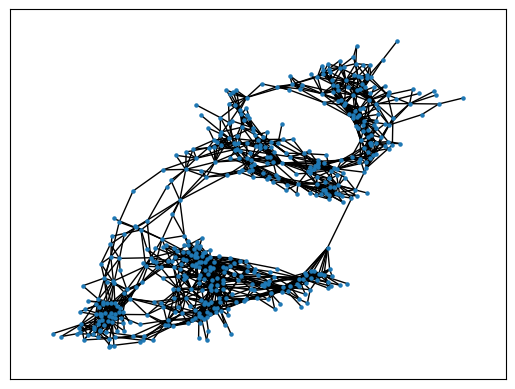

In [20]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)

In [21]:
world_model.v

{'terminal': nan,
 (2, 7, 7, 7, 4, 7, 0, 4): nan,
 (3, 0, 1, 6, 3, 1, 3, 7): nan,
 (1, 0, 1, 6, 3, 1, 3, 7): nan,
 (2, 7, 7, 7, 4, 7, 2, 4): nan,
 (3, 7, 7, 7, 4, 7, 0, 4): nan,
 (3, 1, 4, 5, 1, 2, 1, 6): nan,
 (3, 1, 7, 5, 4, 2, 6, 6): nan,
 (2, 7, 7, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 0, 4): nan,
 (2, 3, 5, 1, 2, 5, 3, 7): nan,
 (2, 3, 1, 1, 2, 1, 3, 7): nan,
 (2, 0, 1, 5, 7, 1, 3, 7): nan,
 (3, 0, 1, 6, 3, 1, 6, 7): nan,
 (3, 7, 4, 7, 6, 5, 2, 5): nan,
 (4, 7, 4, 7, 6, 5, 0, 5): nan,
 (4, 7, 7, 7, 4, 5, 0, 4): nan,
 (5, 1, 7, 0, 6, 2, 0, 1): nan,
 (7, 2, 6, 6, 4, 4, 3, 7): nan,
 (7, 2, 6, 6, 6, 4, 3, 7): nan,
 (7, 2, 6, 6, 3, 4, 3, 7): nan,
 (3, 0, 1, 6, 3, 4, 3, 7): nan,
 (5, 0, 7, 0, 0, 2, 0, 1): nan,
 (3, 1, 7, 5, 0, 2, 0, 6): nan,
 (7, 2, 6, 1, 7, 4, 3, 7): nan,
 (7, 2, 6, 6, 7, 4, 3, 7): nan,
 (2, 2, 1, 1, 7, 4, 3, 7): nan,
 (3, 2, 4, 6, 3, 4, 3, 7): nan,
 (3, 0, 4, 6, 3, 4, 3, 7): nan,
 (3, 3, 2, 4, 1, 2, 1, 6): nan,
 (3, 3, 0, 5, 1, 2, 1,

In [22]:
# agent.get_state_values(state_key)
node_values = {state_key.get(i, -1): v for i, v in world_model.v.items()}
# node_values.pop(-1)

# normalize the node_values
v_max = max([v for v in node_values.values()])
v_min = min([v for v in node_values.values()])
f = lambda v: (v - v_min) / (v_max - v_min)
normed_node_values = {k: f(v) for k, v in node_values.items()}

In [23]:
max([v for k, v in normed_node_values.items()])

nan

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


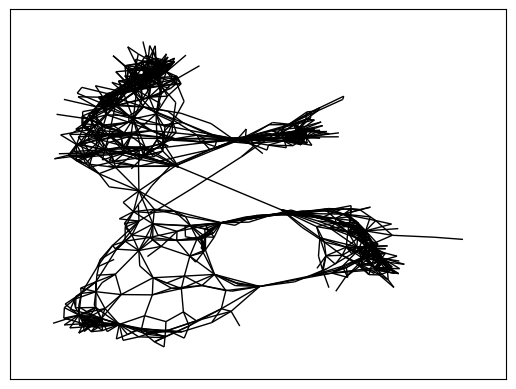

In [24]:
# convert the laplacian into a graph
edges = np.argwhere(Laplacian)
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)

color = [node_values.get(i, 0) for i in G.nodes]
size = [node_values.get(i, 0) * 25 for i in G.nodes]
nx.draw_networkx(G, with_labels=False, node_size=size, node_color=color, cmap="viridis")



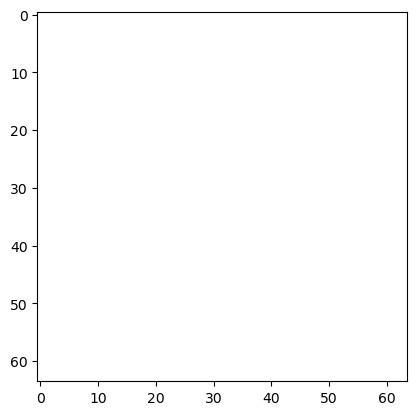

In [25]:
# print(state_key), print(node_values)

obs = None
vs = []
for hashed_state, node in state_key.items():
    v = normed_node_values.get(node, 0)
    vs.append(v)

    z = agent.dehash_states(hashed_state)
    with torch.no_grad():
        obs_ = agent.policy.features_extractor._decode(z.float().flatten())
    if obs is None:
        obs = v * obs_
    else:
        obs += v * obs_
plt.imshow(obs.squeeze().cpu().detach().numpy())
    

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


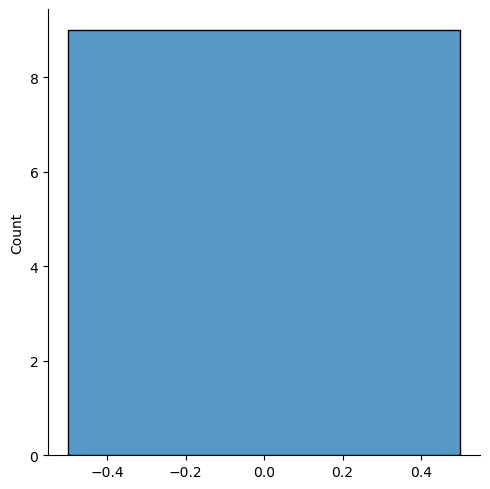

In [27]:
sns.displot(vs)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


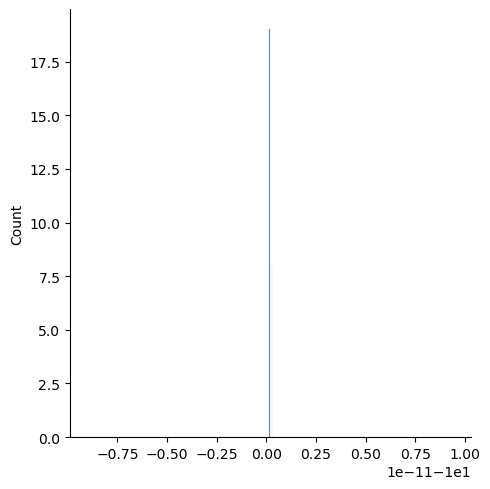

In [26]:
sns.displot([v for v in node_values.values()])

In [ ]:
vae_model = agent.state_inference_model

import torch.nn.functional as F

# Sample generatively

z_layers = vae_config["vae_kwargs"]["z_layers"]
z_dim = vae_config["vae_kwargs"]["z_dim"]

N = 4


def sample_random_state():
    z = torch.randint(high=z_dim, size=tuple([z_layers]))
    return F.one_hot(z, num_classes=z_dim).to(DEVICE)


fig, axes = plt.subplots(N, N, figsize=(9, 9))

vae_model.eval()
for t in range(N**2):
    with torch.no_grad():
        z = sample_random_state()
    X_hat = vae_model.decode(z).detach().cpu()

    r, c = t // N, t % N
    plt.sca(axes[r][c])
    plt.imshow(convert_float_to_8bit(X_hat.squeeze()))
    plt.axis("off")

plt.show()

In [ ]:

pmf = agent.get_policy_prob(agent.get_env(), n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True)
pmf

In [ ]:
# sorted(list(agent.value_function.values()))

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Discrete PPO Agent Learned Policy")

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pi[:, 0].reshape(h, w))
axes[0][1].imshow(pi[:, 1].reshape(h, w))
axes[1][0].imshow(pi[:, 2].reshape(h, w))
axes[1][1].imshow(pi[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Optimal policy")

In [ ]:
np.sum(pi * pmf, axis=1).mean()

In [ ]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])
plt.xticks([0, 1, 2], ["Room 1", "Room 2", "Room 3"])
plt.ylim(0, 1)

sns.despine()

In [ ]:
raise Exception()

In [ ]:
from utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

In [ ]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

In [ ]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

In [ ]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
)[:, None, ...].to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_avg_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

In [ ]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    )[:, None, ...].to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.imshow(v)
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
plt.plot(v[5] - np.nanmin(v))

In [ ]:
raise Exception("Stop here")

In [ ]:
from tqdm import trange


## Repeat with iterations
n_models = 8
# n_models=4


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=False)
    #     agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        vae_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

In [ ]:
# Plot the average value function (n)

# normalize the value function between zero and one within each iteration
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(grouped_data):
    v = grouped_data["State-Values"].values.reshape(-1, 1)
    v = MinMaxScaler().fit_transform(grouped_data["State-Values"].values.reshape(-1, 1))
    grouped_data["State-Values"] = v
    return grouped_data.drop("Iteration", axis=1)


normed_vf = value_functions.groupby("Iteration", group_keys=True).apply(min_max_scale)

# average and plot
plt.imshow(x.groupby("States").mean().values.reshape(20, 20))
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

In [ ]:
# plot 1d Value function through the goal
normed_vf["Row"] = normed_vf["States"] // 20
normed_vf["Column"] = normed_vf["States"] % 20

sns.relplot(
    data=normed_vf[normed_vf["Row"] == 4], x="Column", y="State-Values", kind="line"
)
sns.relplot(
    data=normed_vf[(normed_vf["Column"] >= 9) & (normed_vf["Column"] <= 10)],
    x="Row",
    y="State-Values",
    kind="line",
    hue="Column",
)

plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv('value_functions_vae.csv')

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Model"] = "Value Iteration"
scores.to_csv(SAVE_FILE_NAME)
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"
scores3 = pd.read_csv("sims_thread_the_needle_state_inf.csv")
scores3["Model"] = "Value Iteration + action based decoder"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

In [ ]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])